In [185]:
# importing the needed libraries/packages/modules

import numpy as np
import matplotlib.pyplot as plt

import string
from nltk import punkt
from nltk.tokenize import word_tokenize

from sklearn import datasets
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix

In [186]:
# fetching the training and testing input and output

data_train=datasets.fetch_20newsgroups(subset='train')
data_test=datasets.fetch_20newsgroups(subset='test')

X_train=data_train.data
Y_train=data_train.target

X_test=data_test.data
Y_test=data_test.target

In [187]:
# tokenizing the input 

X_train=[word_tokenize(i) for i in X_train]
X_test=[word_tokenize(i) for i in X_test]

In [188]:
# making list of stop words

stop_words=[]

with open("stop_words.txt") as file_obj :
    for line in file_obj :
        for word in line.split() :
            stop_words.append(word)    

In [189]:
# making list of the special chars

special_chars=list(string.punctuation)
special_chars=np.append(special_chars, np.arange(10))

In [190]:
# dictionary to store the different words and their frequencies

dict={}

In [191]:
# iterating on each data point of the training input

for x in X_train :     
    x_words, x_counts=np.unique([i.lower() for i in x], return_counts=True)

    # iterating on each unique word of a particular data point

    for i in range(len(x_words)) :
        x_word=x_words[i]

        # checking to make sure words with special chars, stop words or length==2(<2 are managed indirectly)are not included in the dictionary

        hasSpecial=False

        for special_char in special_chars :
            if special_char in x_word :
                hasSpecial=True
                break

        if hasSpecial :
            continue
        
        if x_word in stop_words :
            continue    

        if len(x_word)==2 :
            continue

        # adding the valid word to the dictionary with its respective count

        if x_word in dict :
            dict[x_word]+=x_counts[i]
        else :
            dict[x_word]=x_counts[i]    

In [192]:
# sorting the dictionary wrt the frequencies in descending order

dict=sorted(dict.items(), key=lambda item: item[1], reverse=True)

In [193]:
# getting seperate list of all the words and their frequencies 

words=[i[0] for i in dict]
freq=[i[1] for i in dict]

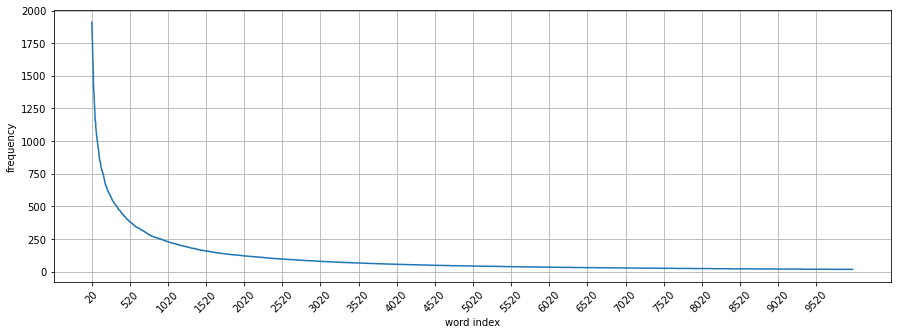

In [194]:
# plotting the words with their frequencies to choose the optimal range(exclusive of the outliers)

plt.figure(figsize=(15, 5))

plt.xlabel("word index")
plt.ylabel("frequency")

lower_limit=20
upper_limit=10000

plt.xticks(np.arange(lower_limit, upper_limit, 500), rotation=45)
plt.plot(np.arange(lower_limit, upper_limit), freq[lower_limit: upper_limit])

plt.grid()
plt.show()

In [195]:
# limiting the words and their frequencies to the above range 

words=words[lower_limit: upper_limit]
freq=freq[lower_limit: upper_limit]

In [196]:
# dictionary to store the index(column number) wrt each word

word_idx={}

for i in range(len(words)) :
    word_idx[words[i]]=i

In [197]:
# function to change the input to a form where each data point has a row corresponding to it, storing the frequencies of the words in the above range ocurring in it 

def modify_input(X) :
    X_mod=np.zeros((len(X), len(words)))

    for i in range(len(X)) :  
        x=X[i]

        x_words, x_count=np.unique([i.lower() for i in x], return_counts=True)    

        for j in range(len(x_words)) :
            x_word=x_words[j]

            if not x_word in words :
                continue

            X_mod[i][word_idx[x_word]]=x_count[j]    

    return X_mod

In [198]:
# modifying the training and testing input

X_train_mod=modify_input(X_train)
X_test_mod=modify_input(X_test)

In [199]:
# making an inbuilt multinomial naive bayes classifier 

clf=MultinomialNB()

In [200]:
# fitting the training data inside the classifier and checking its score on the testing data

clf.fit(X_train_mod, Y_train)
clf.score(X_test_mod, Y_test)

0.8040361125862985

In [201]:
# function to train the classifier and return a corresponding dictionary

def fit(X, Y) :
    # making a dictionary and storing the total count of data points in it

    count={}    
    count["total_count"]=len(Y)

    # iterating on the unique class values in the output 

    class_values=set(Y) 

    for class_value in class_values :
        # making a dictionary for each class

        count[class_value]={}

        # getting input and output corresponding to the current class

        X_class_value=X[Y==class_value]
        Y_class_value=Y[Y==class_value]

        # storing the total count of data points with the current class and initializing word count(to store the total number of words in the data points with the current class)

        count[class_value]["total_count"]=len(Y_class_value)
        count[class_value]["word_count"]=0

        for j in range(X_class_value.shape[1]) :
            # storing the count of a particular word for the data points with the current class and incrementing the word count for the current class

            count[class_value][j]=X_class_value[:, j].sum() 
            count[class_value]["word_count"]+=count[class_value][j]

    return count

In [202]:
# function which returns the log probability(we're considering the log probability as the multiplication of many small probabilities can lead to zero probability which indicates that x cannot belong to a given class which is a bold assumption, which we should not make) that given data point belongs to a given class

def getProb(count, x, class_value) :
    # initializing output with the probability that the class is the current class

    output=(np.log(count[class_value]["total_count"])-np.log(count["total_count"]))   

    # iterating on all the features 

    for i in range(len(x)) :
        # skipping the case when the current word/feature is not present in x

        if x[i]==0 :
            continue    

        # finding the probability that the word is the current word, given that the class is the current class(performing laplace correction as if the count of a particular word of x in the given class is 0, then we should not make a bold assumption that the given word cannot belong to the current class by saying that the corresponding probability is 0)

        count_class_value_wj=(count[class_value][i]+1)
        count_class_value=(count[class_value]["word_count"]+X_train_mod.shape[1])

        # adding the probability to the output

        output+=(np.log(count_class_value_wj)-np.log(count_class_value))

    return output

In [203]:
# function which predicts the class that a particular data point belongs to 

def getClass(count, x) :
    # getting the unqiue classes from the dictionary and then iterating on them

    class_values=count.keys()

    # default values for the best probability and the output

    best_prob=-1
    output=None

    for class_value in class_values :
        # skipping the total count property 

        if class_value=="total_count" :
            continue
        
        # getting the probability that a particular data point belongs to a particular class and then making the necessary updations

        prob_class_value=getProb(count, x, class_value)        

        if(best_prob==-1 or prob_class_value>best_prob) :
            best_prob=prob_class_value
            output=class_value

    return output

In [204]:
# predict function which returns the predictions for the test input

def predict(count, X) :
    Y_pred=[]

    for x in X :
        # getting the class which each test data point belongs to
        
        x_class=getClass(count, x)
        Y_pred.append(x_class)

    return Y_pred

In [205]:
# score function which returns the mean accuracy of the model

def score(Y_true, Y_pred) :
    count=0

    for i in range(len(Y_pred)) :
        if(Y_pred[i]==Y_true[i]) :
            count+=1

    return (count/len(Y_pred))

In [206]:
# fitting the training data into the multinomial naive bayes classifier and getting the correponding dictionary

count=fit(X_train_mod, Y_train)

In [207]:
# getting the predictions for the testing data

Y_pred=predict(count, X_test_mod)

In [208]:
# getting the score of the classifier on the testing data

score(Y_test, Y_pred)

0.7955390334572491

In [209]:
# printing the classification report and the confusion matrix for better understanding

print(classification_report(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       319
           1       0.58      0.76      0.66       389
           2       0.76      0.58      0.66       394
           3       0.67      0.69      0.68       392
           4       0.70      0.81      0.75       385
           5       0.88      0.69      0.77       395
           6       0.79      0.84      0.81       390
           7       0.86      0.88      0.87       396
           8       0.88      0.94      0.91       398
           9       0.94      0.91      0.92       397
          10       0.96      0.94      0.95       399
          11       0.88      0.88      0.88       396
          12       0.77      0.67      0.71       393
          13       0.92      0.83      0.87       396
          14       0.88      0.90      0.89       394
          15       0.81      0.88      0.84       398
          16       0.68      0.91      0.78       364
          17       0.97    